# LTFS Preprocessing + Baseline

## Импорты и загрузка датасета

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, log_loss, classification_report, roc_curve


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(15, 7)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
train_df = pd.read_csv("https://raw.githubusercontent.com/blnglishPlease/LCSM/main/LTFS/data/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/blnglishPlease/LCSM/main/LTFS/data/test.csv")

In [3]:
train_df.head().T

,0,1,2,3,4
UniqueID,420825,537409,417566,624493,539055
disbursed_amount,50578,47145,53278,57513,52378
asset_cost,58400,65550,61360,66113,60300
ltv,89.55,73.23,89.63,88.48,88.39
branch_id,67,67,67,67,67
supplier_id,22807,22807,22807,22807,22807
manufacturer_id,45,45,45,45,45
Current_pincode_ID,1441,1502,1497,1501,1495
Date.of.Birth,01-01-84,31-07-85,24-08-85,30-12-93,09-12-77
Employment.Type,Salaried,Self employed,Self employed,Self employed,Self employed


In [4]:
X = train_df.copy().drop('loan_default', axis=1)
y = train_df['loan_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=42)

## Preprocessing

In [5]:
def to_dates(df_, column):
  df = df_.copy()
  df[column + '_day'] = df[column].apply(lambda x: x.day)
  df[column + '_month'] = df[column].apply(lambda x: x.month)
  # df[column + '_year'] = df[column].apply(lambda x: x.year)
  return df

In [6]:
def get_month_cnt(string):
  digits = re.findall(r'(\d+)', string=string)
  yrs = int(digits[0])
  mon = int(digits[1])
  return (yrs * 12) + mon

In [7]:
class Preprocessor:
  def fit(self, X, y):
    return self

  def transform(self, X):
    self.df = X.copy()

    # Заполнение пропусков в типе занятости
    self.df['Employment.Type'] = self.df['Employment.Type'].fillna('Self employed')
    self.df['is_salaried'] = pd.get_dummies(data=self.df['Employment.Type'])['Salaried']

    # Конвертация дат
    self.df['Date.of.Birth'] = pd.to_datetime(self.df['Date.of.Birth'], format='%d-%m-%y')
    self.df['DisbursalDate'] = pd.to_datetime(self.df['DisbursalDate'], format='%d-%m-%y')

    # Корректировки неправильно распознанных дат из-за двух символов для обозначения года
    future = self.df['Date.of.Birth'] > max(self.df['DisbursalDate'])
    self.df.loc[future, 'Date.of.Birth'] -= np.timedelta64(100, 'Y')

    # Разбиение дат на день + месяц + год 
    # self.df = to_dates(self.df, 'Date.of.Birth')
    self.df = to_dates(self.df, 'DisbursalDate')

    # Расчет возраста
    self.df['Age'] = ((self.df['DisbursalDate'] - self.df['Date.of.Birth']) / np.timedelta64(1, 'Y')).apply(lambda x: int(x))

    # Приведение промежутков времени к числу месяцев
    self.df['CREDIT.HISTORY.LENGTH'] = self.df['CREDIT.HISTORY.LENGTH'].apply(lambda x: get_month_cnt(x))
    self.df['AVERAGE.ACCT.AGE'] = self.df['AVERAGE.ACCT.AGE'].apply(lambda x: get_month_cnt(x))

    # Корректировки отрицательных значений
    self.df['PRI.CURRENT.BALANCE'] = self.df['PRI.CURRENT.BALANCE'].apply(lambda x: max(x, 0))
    self.df['SEC.CURRENT.BALANCE'] = self.df['SEC.CURRENT.BALANCE'].apply(lambda x: max(x, 0))

    columns_to_drop = ['branch_id', 'UniqueID', 'MobileNo_Avl_Flag', 'supplier_id', \
                 'Current_pincode_ID', 'Employee_code_ID', 'DisbursalDate', \
                 'Date.of.Birth', 'PERFORM_CNS.SCORE.DESCRIPTION', 'Employment.Type']
    self.df.drop(columns_to_drop, axis=1, inplace=True)

    return self.df

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X)


## Pipeline

In [8]:
categorical_features = ['manufacturer_id', 'State_ID', 'Aadhar_flag', \
                        'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', \
                        'DisbursalDate_day', 'DisbursalDate_month', 'is_salaried']

num_features = ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE', \
                'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', \
                'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', \
                'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', \
                'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', \
                'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', \
                'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', \
                'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'Age']

len(categorical_features) + len(num_features)

34

In [9]:
transformer = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown = 'ignore'), categorical_features),
        ('scaler', MinMaxScaler(), num_features)
    ],
    remainder = 'passthrough'
)

In [10]:
model_pipeline = Pipeline([
    ('preprocessing', Preprocessor()),
    ('transforming', transformer),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [11]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 <__main__.Preprocessor object at 0x7fe091554fd0>),
                ('transforming',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer_id',
                                                   'State_ID', 'Aadhar_flag',
                                                   'PAN_flag', 'VoterID_flag',
                                                   'Driving_flag',
                                                   'Passport_flag',
                                                   'DisbursalDate_day',
                                                   'Disburs...
                                                   'SEC.NO.OF.ACCTS',
                                                   'SEC.ACTIVE.ACCTS',
                                                   'SEC.OVERDUE.ACCTS',
                                                   'SEC.CURRENT.BALANCE',
                                                   'SEC.SANCTIONED.AMOUNT',
                                                   'SEC.DISBURSED.AMOUNT',
                                                   'PRIMARY.INSTAL.AMT',
                                                   'SEC.INSTAL.AMT',
                                                   'NEW.ACCTS.IN.LAST.SIX.MONTHS',
                                                   'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
                                                   'AVERAGE.ACCT.AGE',
                                                   'CREDIT.HISTORY.LENGTH',
                                                   'NO.OF_INQUIRIES',
                                                   'Age'])])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [12]:
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)

In [13]:
print("roc_auc: {:.4f}".format(roc_auc_score(y_test, y_proba[:,1])))
print("precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("f1: {:.4f}".format(f1_score(y_test, y_pred)))
print("logloss: {:.4f}".format(log_loss(y_test, y_pred)))

roc_auc: 0.6436
precision: 0.2912
recall: 0.6323
f1: 0.3988
logloss: 14.9173


In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(model_pipeline, X, y, cv=skf)
print("CV accuracy score: {:.2f}%".format(results.mean() * 100))

CV accuracy score: 58.58%


In [15]:
! pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from scikitplot.metrics import plot_roc

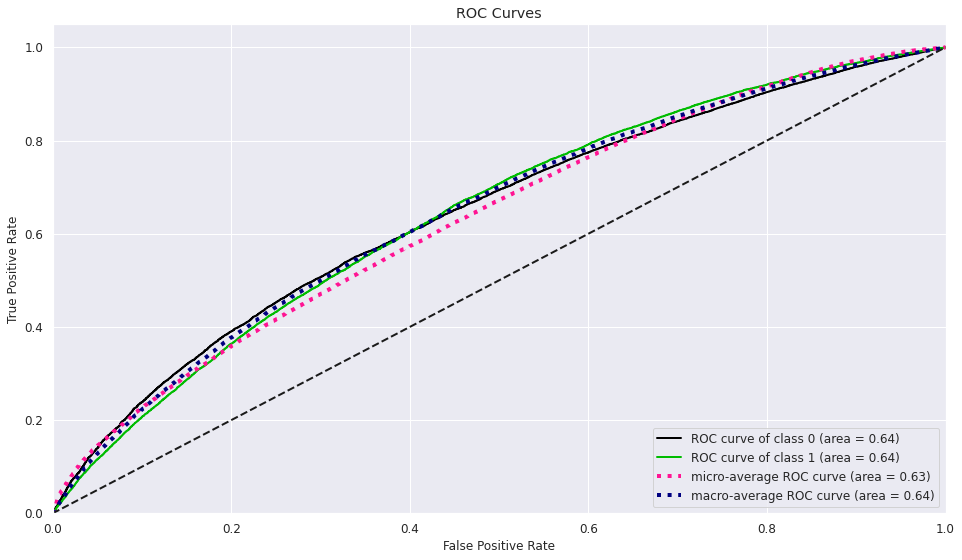

In [17]:
plot_roc(y_test, y_proba, figsize = (16, 9))
plt.show()



---

